In [1]:
from typing import Callable, List, Optional, Iterable
from pathlib import Path
import os
from copy import deepcopy
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp
from tabulate import tabulate
import warnings

import scipy

warnings.filterwarnings("ignore")

DATA_DIR = "./expt_rslts/"
PICKLE_NAME = "nn_rslts_df.pkl"
IMG_OUTPUT_DIR = Path("imgs/")
IMG_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
TABLE_OUTPUT_DIR = Path("tables/")
TABLE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#OPT_OF_INTEREST = ("sgd", "kn", "fr", "pr", "hs", "dy", "bfgs")
#DISCRIMINATE_FGD = False
#if DISCRIMINATE_FGD:
#    OPT_OF_INTEREST = ("fgd", "sgd", "kn", "fr", "pr", "hs", "dy", "bfgs")

# Truncate the opts of interest...
OPT_OF_INTEREST = ("sgd", "fr", "bfgs")


DROP_N_EQUALS_TWO = True

NAME_DICT = {
    "sgd": "Stochastic Gradient Descent",
    "fgd": "Full Gradient Descent",
    "kn": "Krylov-Newton",
    "fr": "Fletcher-Reeves",
    "pr": "Polak-Ribiere",
    "hs": "Hestenes-Stiefel",
    "dy": "Dai-Yuan",
    "bfgs": "BFGS",
    "bfgsi": "BFGS Inverse",
    "dfp": "Davidon-Fletcher-Powell",
    "dfpi": "Davidon-Fletcher-Powell Inverse",
    "sr1": "Symmetric Rank-One",
    "sr1d": "Symmetric Rank-One Dual",
    "levenberg": "Levenberg"
}

def read_json_to_df(fname):
    try:
        with open(fname) as f:
            tmp_df = pd.json_normalize(json.load(f))
            return tmp_df
    except Exception:
        return None

if not os.path.exists(PICKLE_NAME):
    print("Creating dataframe!")
    assert(os.path.exists(DATA_DIR))
    f_list = glob.glob(os.path.join(DATA_DIR, "TEST_*.json"))
    print("Number of files:", len(f_list))
    with mp.Pool() as p:
        dframes = p.map(read_json_to_df, f_list)
    #dframes = [read_json_to_df(i) for i in f_list]
    dframes = [i for i in dframes if i is not None]
    monolith = pd.concat(dframes)
    monolith.to_pickle(PICKLE_NAME)

else:
    print("Reading dataframe!")
    monolith = pd.read_pickle(PICKLE_NAME)

monolith.keys()
cifar = monolith.loc[monolith["specs.dataset"] == "cifar10"]
cifar["specs.batch_size_train"] = cifar["specs.batch_size_train"].apply(int)

Reading dataframe!


In [2]:
def max_acc_lambda(row):
    try:
        max_ = max(row["test_accuracy_list"])
    except ValueError:
        max_ = 0.0
    return max_

def final_acc_lambda(row):
    try:
        last = row["test_accuracy_list"][-1]
    except IndexError:
        last = float("NaN")
    return last

cumulative_time_lambda = lambda row: np.cumsum(row["time"])

def total_time_lambda(row):
    try:
        max_ = row["training_timestamps"][-1]
    except IndexError:
        max_ = float("NaN")
    return max_

def time_to_peak_lambda(row):
    try:
        max_idx = np.array(row["test_accuracy_list"]).argmax()
        time_to_peak = np.sum(row["training_timestamps"][:max_idx+1])

    except ValueError:
        time_to_peak = np.nan

    return time_to_peak


def fgd_lambda(row):
    try:
        opt_name = row["specs.opt"]
        batch_size_train = int(row["specs.batch_size_train"])
        if opt_name == "sgd" and batch_size_train >= 50000:
            row["specs.opt"] = "fgd"
    except ValueError:
        print(f"row failed: {row['specs.opt']}")


def apply_lambda(df: pd.DataFrame, colname: str, func: Callable):
    tmp = df.apply(func, axis=1)
    df[colname] = tmp.copy()

    return df

def get_summary_vals(df: pd.DataFrame):
    df = apply_lambda(df, "top_test_acc", max_acc_lambda)
    df = apply_lambda(df, "final_test_acc", final_acc_lambda)
    df = apply_lambda(df, "training_timestamps", cumulative_time_lambda)
    df = apply_lambda(df, "total_training_time", total_time_lambda)
    df = apply_lambda(df, "time_to_peak_acc", time_to_peak_lambda)
    df = df.dropna(subset=["total_training_time"])
    if DROP_N_EQUALS_TWO:
        df = df[df["specs.batch_size_train"] > 2]

    return df

cifar = get_summary_vals(cifar)
cifar = cifar.loc[cifar["specs.opt"].isin(OPT_OF_INTEREST)]
def drop_fr_5k_failure_to_train(df: pd.DataFrame):
    """Handle the weird case of FR failing to train at 5k batch size"""
    return df.loc[~((df["specs.opt"] == "fr") & (df["top_test_acc"] < 15))]

cifar = drop_fr_5k_failure_to_train(cifar)

In [3]:
dfs = [(opt, cifar.loc[cifar["specs.opt"] == opt]["time_to_peak_acc"]) for opt in OPT_OF_INTEREST]

In [4]:
longest_data = max([len(series.values) for _, series in dfs])
tmp_array = np.empty((longest_data, 3))
tmp_array[:] = np.nan
opts = []
for i, (opt, series) in enumerate(dfs):
    print(opt)
    print(series.shape)
    val = series.values
    length = val.shape[-1]
    tmp_array[:length, i] = val[:]
    opts.append(opt)
    
time_to_peak_df = pd.DataFrame(data=tmp_array, columns=opts)

sgd
(826,)
fr
(684,)
bfgs
(626,)


In [5]:
print(time_to_peak_df)

              sgd             fr           bfgs
0    7.030884e+04  167035.930627    4925.489988
1    2.651531e+04   45286.294907   64316.351252
2    9.552891e+04   51635.761606   56019.708565
3    1.654074e+06  684261.646179   55853.152005
4    1.747586e+05  124160.965640  119112.549536
..            ...            ...            ...
821  2.048776e+03            NaN            NaN
822  4.445905e+03            NaN            NaN
823  1.534102e+04            NaN            NaN
824  3.036421e+05            NaN            NaN
825  5.010043e+03            NaN            NaN

[826 rows x 3 columns]


Text(0.5, 1.0, 'Optimizer Runtime Distributions, bad FR removed, no outlier treatment')

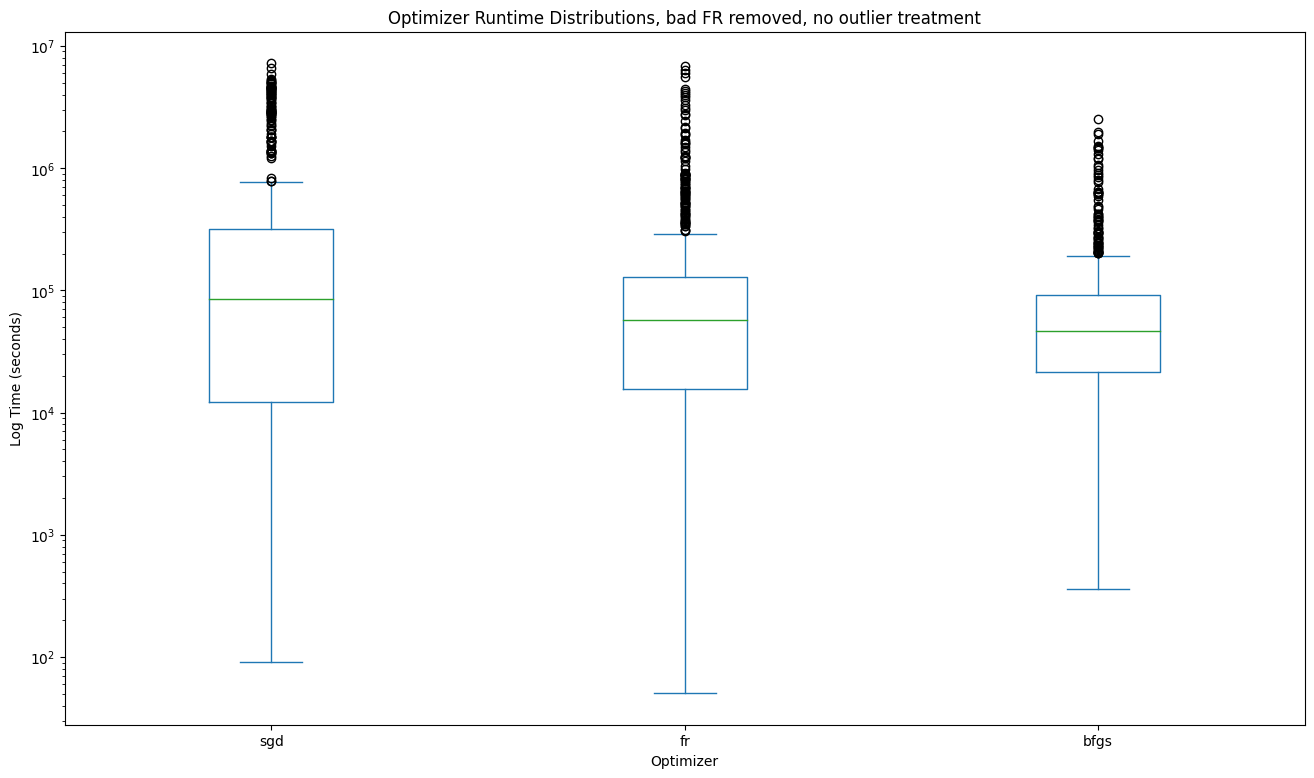

In [6]:
ax = time_to_peak_df.plot(kind="box")
ax.figure.set_size_inches(16, 9)
ax.set_yscale("log")
ax.set_ylabel("Log Time (seconds)")
ax.set_xlabel("Optimizer")
ax.plot()
ax.set_title("Optimizer Runtime Distributions, bad FR removed, no outlier treatment")

In [7]:
def remove_outliers(series: pd.Series):
    Q1 = series.quantile(q=0.25)
    Q2 = series.quantile(q=0.75)
    iqr = scipy.stats.iqr(series)
    range_ = 1.5*iqr
    series.loc[(series > Q2 + range_) | (series < Q1 - range_)] = np.nan
    #series.between(Q1 - (iqr*1.5), Q2 + (iqr*1.5), inclusive=False)
    return series

    

In [8]:
time_to_peak_df["sgd"] = remove_outliers(time_to_peak_df["sgd"])
time_to_peak_df["bfgs"] = remove_outliers(time_to_peak_df["bfgs"])
time_to_peak_df["fr"] = remove_outliers(time_to_peak_df["fr"])

Text(0.5, 1.0, 'Optimizer Runtime Distributions, bad FR removed, Outliers Treated')

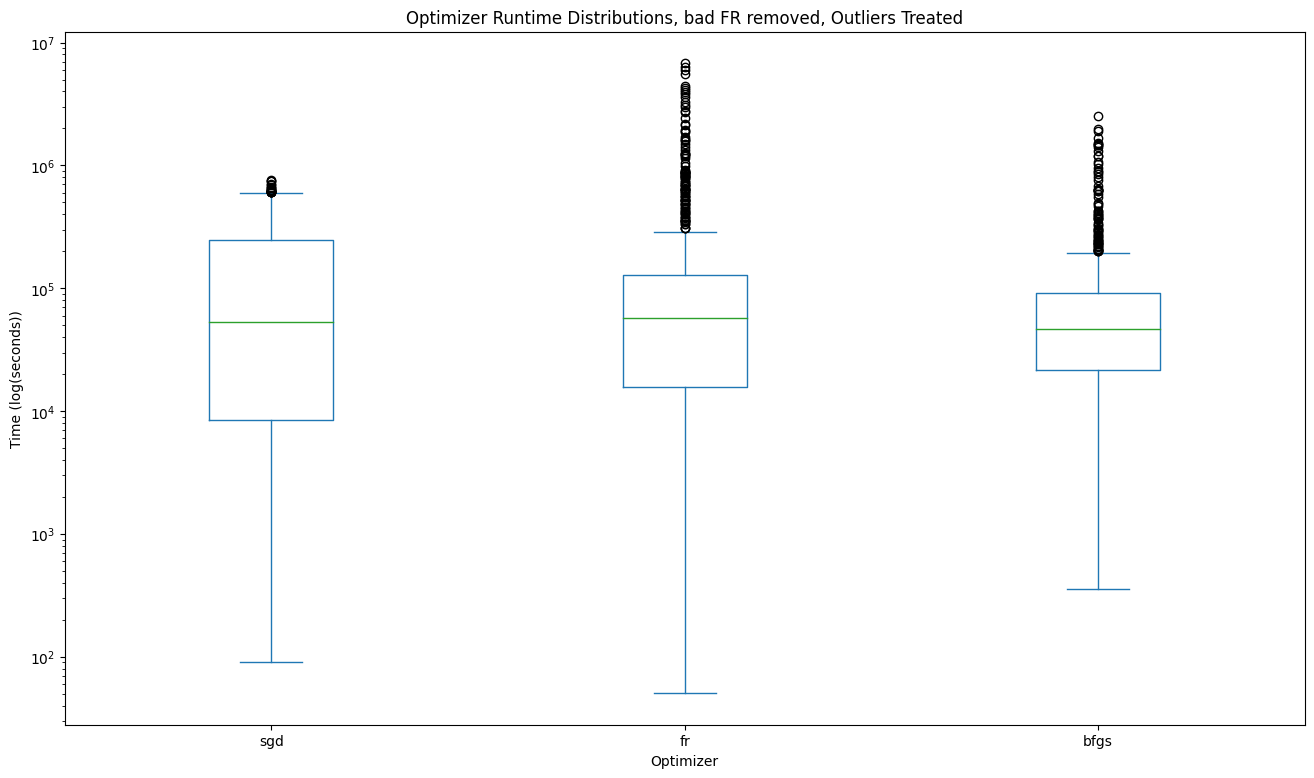

In [9]:
ax = time_to_peak_df.plot(kind="box")
ax.figure.set_size_inches(16, 9)
ax.set_yscale("log")
ax.set_ylabel("Time (log(seconds))")
ax.set_xlabel("Optimizer")
ax.plot()
ax.set_title("Optimizer Runtime Distributions, bad FR removed, Outliers Treated")